In [1]:
import dask.dataframe as dd
import dask.array as da
import os
import csv
import numba
import numpy as np
import math as m
from tqdm import tqdm_notebook
import pandas as pd
import dask
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
from skimage import exposure
from scipy.interpolate import interp1d
import dask_full_scene_analysis_helpers as hlp

In [6]:
solar_path = 'Aug14SolarRef.dat'
HySICS_wl_path = 'HySICS files/WLHysics.sav'

HySICS_LW_data_path = 'Desert_vegetation_clouds/'
LW_datacube_path = 'data_cube_water.npy'
LW_sample_path = 'HySICS files/DSSampleHysics.sav'
LW_rgb_path = 'rgb_water.npy'
LRT_LW_path = 'WC files/'
verbose_LW_path = 'WC files/verbose/'

HySICS_IC_data_path = 'Thick_clouds1/'
IC_datacube_path = 'data_cube_ice.npy'
IC_sample_path = 'HySICS files/CLSampleHysics.sav'
IC_rgb_path = 'rgb_ice.npy'
LRT_IC_path = 'IC files/ghm/'
verbose_IC_path = 'IC files/ghm/verbose/'

HySICS_DS_data_path = 'HySICS files/DSSampleHysics.sav'
LRT_nocloud_data = 'HySICS files/UVSPEC_DVC_noclouds.dat'

In [5]:
def read_HySICS(file, wl_file):
    wlHy = sio.readsav(wl_file)
    wlHy = wlHy['wlsample']
    wlHy_shifted = [x+3.5 for x in wlHy]
    
    ground = sio.readsav(file)
    ground = ground['dssample']
    hysics = xr.DataArray(ground, dims=['wavelength'], name='hysics_radiances', coords={'wavelength':wlHy_shifted})
    return hysics;
hysics = read_HySICS(LW_sample_path,HySICS_wl_path)
hysics

<xarray.DataArray 'hysics_radiances' (wavelength: 640)>
array([0.00305 , 0.002789, 0.002804, ..., 0.26938 , 0.086208, 0.05148 ])
Coordinates:
  * wavelength  (wavelength) float64 2.305e+03 2.302e+03 ... 331.1 328.1

In [7]:
def read_LRT(file):
    data = [x for x in csv.reader(open(file,'r'),delimiter='\t')]
    
    loops = int(len(data)/3)
    dirL = [np.float(data[3*n+2][0][9:24]) for n in range(loops)]#Direct Radiance (W/m^2/nm/sr)
    wl = [np.float(data[3*n][0][1:9]) for n in range(loops)]#Wavelength (nm)       

    dirLW = [i*10**-3 for i in dirL] #convert to W/m^2/nm/sr
    
    lrt_radiances = xr.DataArray(dirLW, dims=['wavelength'], name='LRT', coords={'wavelength':wl})
    return lrt_radiances;

def filter_wl(da):
    wl_min = 450 ; wl_max = 2300
    daf = da.where(da.wavelength>wl_min, drop=True)
    daf = daf.where(da.wavelength<wl_max, drop=True)
    return daf;

lrt = read_LRT(LRT_nocloud_data)

(450, 2250)

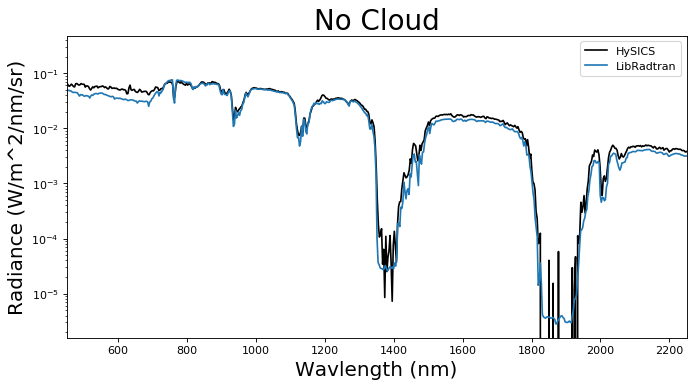

In [11]:
plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.semilogy(hysics.wavelength,hysics.values,'k',label='HySICS')
plt.semilogy(lrt.wavelength,lrt.values,label='LibRadtran')
plt.xlabel('Wavlength (nm)',fontsize=18)
plt.ylabel('Radiance (W/m^2/nm/sr)',fontsize=18)
tt = 'No Cloud'
plt.title(tt,fontsize=25)
plt.legend()
plt.xlim(450,2250)